In [1]:
import math
import warnings

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import linear_model
import statsmodels.formula.api as smf
from scipy.stats import mstats
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, cross_val_predict
from scipy.stats import boxcox
from sklearn.metrics import confusion_matrix
import random
import warnings

# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

# Suppress annoying harmless error.
warnings.simplefilter(action='ignore', category=FutureWarning)

# Data

## Import

I originally built my models from Florida crime data (2017), and will use crime data from Michigan, North Carolina and Ohio to validate the models.

In [2]:
florida = pd.read_excel('./florida_2017.xls')
headers = ['city', 'population', 'violent_crime', 'murder', 'rape', 'robbery',
       'assault', 'property_crime', 'burglary', 'larceny_theft',
       'motor_vehicle_theft', 'arson']
florida.columns = headers
florida.set_index('city', inplace=True)

# read in other states for validation purposes
ohio = pd.read_excel('./ohio_2017.xls')
ohio.columns = headers
ohio.set_index('city', inplace=True)

michigan = pd.read_excel('./michigan_2017.xls')
michigan.columns = headers
michigan.set_index('city', inplace = True)

north_carolina = pd.read_excel('./north-carolina_2017.xls')
north_carolina.columns = headers
north_carolina.set_index('city', inplace=True)


crime_cols = ['violent_crime', 'murder', 'rape', 'robbery', 
              'assault', 'property_crime', 'burglary', 'larceny_theft', 
              'motor_vehicle_theft', 'arson']
# so we will want to remove some outliers
florida = florida[florida.population<florida.population.quantile(0.9)]
michigan = michigan[michigan.population < michigan.population.quantile(0.9)]
north_carolina = north_carolina[north_carolina.population < north_carolina.population.quantile(0.9)]
ohio = ohio[ohio.population < ohio.population.quantile(0.9)]

## Transform

I previously conducted [research](https://github.com/mkm29/DataScience/blob/master/thinkful/unit/2/4/challenge_crime_regression.ipynb) into optimal feature engineering, so I am simply going to use only the transformations that I ended up using in my models.

In [3]:
# add a log odds variable (do not include property crimes though)
cols = ['violent_crime', 'murder', 'rape', 'robbery', 
        'assault', 'burglary', 'larceny_theft', 
        'motor_vehicle_theft', 'arson']
florida["log_odds"] = np.log1p(florida.population / florida[cols].sum(axis=1))
michigan["log_odds"] = np.log1p(michigan.population / michigan[cols].sum(axis = 1))
north_carolina["log_odds"] = np.log1p(north_carolina.population / north_carolina[cols].sum(axis=1))
ohio["log_odds"] = np.log1p(ohio.population / ohio[cols].sum(axis=1))

In [4]:
# log population
florida["population_log"] = np.log(florida.population)
michigan["population_log"] = np.log(michigan.population)
north_carolina["population_log"] = np.log(north_carolina.population)
ohio["population_log"] = np.log(ohio.population)

# log1p first adds 1 to x then logs the result
florida["property_crime_log"] = np.log1p(florida.property_crime)
michigan["property_crime_log"] = np.log1p(michigan.property_crime)
north_carolina["property_crime_log"] = np.log1p(north_carolina.property_crime)
ohio["property_crime_log"] = np.log1p(ohio.property_crime)

# create a population_medium indicator variable
# these are going to be relative to the population in each state
# the medium group is the interquartile range on population (between 1st and 3rd quantiles)
florida["population_medium"] = (florida.population.between(3620.0, 24929.5)).astype("int")
michigan["population_medium"] = (michigan.population.between(1882.0, 9860.0)).astype("int")
north_carolina["population_medium"] = (north_carolina.population.between(2344.0, 10823.0)).astype("int")
ohio["population_medium"] = (ohio.population.between(3566.0,13972.0)).astype("int")

# create n population groups
florida["population_group"] = pd.cut(florida.population, 5, labels=list(range(1,6)))
michigan["population_group"] = pd.cut(michigan.population, 5, labels=list(range(1,6)))
north_carolina["population_group"] = pd.cut(north_carolina.population, 5, labels=list(range(1,6)))
ohio["population_group"] = pd.cut(ohio.population, 5, labels=list(range(1,6)))

# create robbery dummy var
florida["has_robbery"] = np.where(florida.robbery>0,1,0)
michigan["has_robbery"] = np.where(michigan.robbery>0,1,0)
north_carolina["has_robbery"] = np.where(north_carolina.robbery>0,1,0)
ohio["has_robbery"] = np.where(ohio.robbery>0,1,0)

# because box-cox transforms require x>0, when property_crime is 0 we add 1, else we leave it alone
florida["property_crime_2"] = florida["property_crime"].apply(lambda x: x+1 if x == 0 else x)
michigan["property_crime_2"] = michigan["property_crime"].apply(lambda x: x+1 if x == 0 else x)
north_carolina["property_crime_2"] = north_carolina["property_crime"].apply(lambda x: x+1 if x == 0 else x)
ohio["property_crime_2"] = ohio["property_crime"].apply(lambda x: x+1 if x == 0 else x)


# burglary_cube_root
florida["burglary_cube_root"] = florida.burglary**(1/3)
michigan["burglary_cube_root"] = michigan.burglary**(1/3)
north_carolina["burglary_cube_root"] = north_carolina.burglary ** (1/3)
ohio["burglary_cube_root"] = ohio.burglary ** (1/3)

# assault_log
florida["assault_log"] = np.log1p(florida.assault)
michigan["assault_log"] = np.log1p(michigan.assault)
north_carolina["assault_log"] = np.log1p(north_carolina.assault)
ohio["assault_log"] = np.log1p(ohio.assault)

# larceny_theft_cube_root
florida["larceny_theft_cube_root"] = florida.larceny_theft ** (1/3)
michigan["larceny_theft_cube_root"] = michigan.larceny_theft ** (1/3)
north_carolina["larceny_theft_cube_root"] = north_carolina.larceny_theft ** (1/3)
ohio["larceny_theft_cube_root"] = ohio.larceny_theft ** (1/3)

# robbery_log
florida["robbery_log"] = np.log1p(florida.robbery)
michigan["robbery_log"] = np.log1p(michigan.robbery)
north_carolina["robbery_log"] = np.log1p(north_carolina.robbery)
ohio["robbery_log"] = np.log1p(ohio.robbery)

# motor_vehicle_theft_log
florida["motor_vehicle_theft_log"] = np.log1p(florida.motor_vehicle_theft)
michigan["motor_vehicle_theft_log"] = np.log1p(michigan.motor_vehicle_theft)
north_carolina["motor_vehicle_theft_log"] = np.log1p(north_carolina.motor_vehicle_theft)
ohio["motor_vehicle_theft_log"] = np.log1p(ohio.motor_vehicle_theft)



**Box-Cox transform property crime**

In [5]:
bc1 = boxcox(florida["property_crime_2"])
florida['property_crime_bc'] = bc1[0]
florida_bc_lambda = bc1[1]

bc2 = boxcox(michigan["property_crime_2"])
michigan['property_crime_bc'] = bc2[0]
michigan_bc_lambda = bc2[1]

bc3 = boxcox(north_carolina["property_crime_2"])
north_carolina['property_crime_bc'] = bc3[0]
north_carolina_bc_lambda = bc3[1]

bc4 = boxcox(ohio["property_crime_2"])
ohio['property_crime_bc'] = bc4[0]
ohio_bc_lambda = bc4[1]

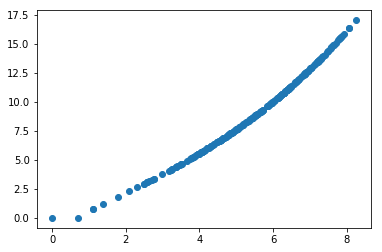

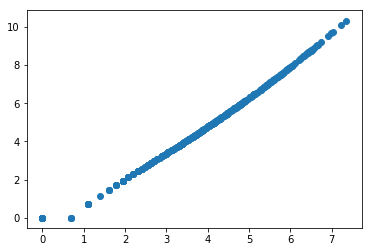

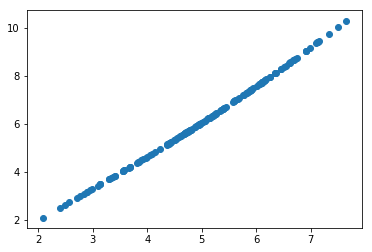

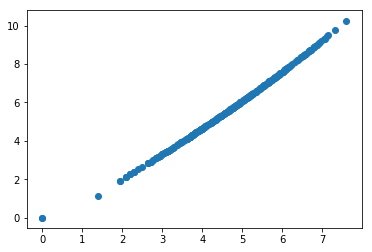

In [6]:
plt.scatter(florida["property_crime_log"], bc1[0])
plt.show()
plt.scatter(michigan["property_crime_log"], bc2[0])
plt.show()
plt.scatter(north_carolina["property_crime_log"], bc3[0])
plt.show()
plt.scatter(ohio["property_crime_log"], bc4[0])
plt.show()

## Split

Split each state's data into a train and test set.

In [7]:
florida_train = florida.sample(frac=0.7, random_state=41)
florida_test_cities = list(set(florida.index).difference(set(florida_train.index)))
florida_test = florida.loc[florida_test_cities,:]
print("Train shape: {}".format(florida_train.shape))
print("Test shape: {}".format(florida_test.shape))

Train shape: (178, 24)
Test shape: (77, 24)


In [8]:
michigan_train = michigan.sample(frac=0.7, random_state=41)
michigan_test_cities = list(set(michigan.index).difference(set(michigan_train.index)))
michigan_test = michigan.loc[michigan_test_cities,:]
print("Train shape: {}".format(michigan_train.shape))
print("Test shape: {}".format(michigan_test.shape))

Train shape: (265, 24)
Test shape: (114, 24)


In [9]:
north_carolina_train = north_carolina.sample(frac=0.7, random_state=41)
north_carolina_test_cities = list(set(north_carolina.index).difference(set(north_carolina_train.index)))
north_carolina_test = north_carolina.loc[north_carolina_test_cities,:]
print("Train shape: {}".format(north_carolina_train.shape))
print("Test shape: {}".format(north_carolina_test.shape))

Train shape: (118, 24)
Test shape: (51, 24)


In [10]:
ohio_train = ohio.sample(frac=0.7, random_state=41)
ohio_test_cities = list(set(ohio.index).difference(set(ohio_train.index)))
ohio_test = ohio.loc[ohio_test_cities,:]
print("Train shape: {}".format(ohio_train.shape))
print("Test shape: {}".format(ohio_test.shape))

Train shape: (233, 24)
Test shape: (100, 24)


# Model

For this exercise, we are simply going to use model 3 from the previous exercise:

\begin{equation}\label{eq:}
PropertyCrime_{BoxCox} = 0.1328*Population_{log} + 0.5590*Robbery_{has} + 0.3989*Population_{Medium} - 0.1726*Robbery_{log} + 0.4324*\sqrt[3]{Burglary} + 0.8481*\sqrt[3]{Larceny} + 0.2094*VehicleTheft
\end{equation}


In [11]:
# Now lets see how well we can predict the boxcox transform of property_crime

model_vars = ['population_log', 'has_robbery', 
              'population_medium',
              "robbery_log", "burglary_cube_root",
              "larceny_theft_cube_root", "motor_vehicle_theft_log"]


formula = "property_crime_bc ~ " + ' + '.join(model_vars)
lm_florida = smf.ols(formula=formula, data=florida_train).fit()
lm_florida.summary()

model = LinearRegression()
model.fit(florida_train[model_vars], florida_train["property_crime_bc"])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [12]:
model = LinearRegression()
model.fit(florida_train[model_vars], florida_train["property_crime_bc"])

y_pred = cross_val_predict(model, florida_train[model_vars], florida_train["property_crime_bc"])
cv = cross_val_score(model, florida_train[model_vars], florida_train["property_crime_bc"], cv=5)
print("Florida: Train\n-------------------------------------------------------------\n")
print(cv)
print("cv average is = {:.2f}%".format(cv.mean()*100))

model = LinearRegression()
model.fit(florida_test[model_vars], florida_test["property_crime_bc"])

y_pred = cross_val_predict(model, florida_test[model_vars], florida_test["property_crime_bc"])
cv = cross_val_score(model, florida_test[model_vars], florida_test["property_crime_bc"], cv=5)
print("\nFlorida: Test\n-------------------------------------------------------------\n")
print(cv)
print("cv average is = {:.2f}%".format(cv.mean()*100))

Florida: Train
-------------------------------------------------------------

[0.98927829 0.99120578 0.99214133 0.99412577 0.99172054]
cv average is = 99.17%

Florida: Test
-------------------------------------------------------------

[0.98129632 0.98384013 0.99050872 0.98460912 0.94591881]
cv average is = 97.72%


In [13]:
model2 = LinearRegression()
model2.fit(michigan_train[model_vars], michigan_train["property_crime_bc"])

y_pred2 = cross_val_predict(model2, michigan_train[model_vars], michigan_train["property_crime_bc"])
cv2 = cross_val_score(model2, michigan_train[model_vars], michigan_train["property_crime_bc"], cv=5)
print("Michigan: Train\n-------------------------------------------------------------\n")
print(cv2)
print("cv average is = {:.2f}%".format(cv2.mean()*100))

model3 = LinearRegression()
model3.fit(michigan_test[model_vars], michigan_test["property_crime_bc"])

y_pred3 = cross_val_predict(model3, michigan_test[model_vars], michigan_test["property_crime_bc"])
cv3 = cross_val_score(model3, michigan_test[model_vars], michigan_test["property_crime_bc"], cv=5)
print("\Michigan: Test\n-------------------------------------------------------------\n")
print(cv3)
print("cv average is = {:.2f}%".format(cv3.mean()*100))

Florida: Train
-------------------------------------------------------------

[0.98142064 0.97498128 0.97110761 0.97513666 0.98209063]
cv average is = 97.69%

Florida: Test
-------------------------------------------------------------

[0.97807477 0.96783801 0.97896    0.94942933 0.92304751]
cv average is = 95.95%


In [16]:
model4 = LinearRegression()
model4.fit(north_carolina_train[model_vars], north_carolina_train["property_crime_bc"])

y_pred4 = cross_val_predict(model4, north_carolina_train[model_vars], north_carolina_train["property_crime_bc"])
cv4 = cross_val_score(model4, north_carolina_train[model_vars], north_carolina_train["property_crime_bc"], cv=5)
print("North Carolina: Train\n-------------------------------------------------------------\n")
print(cv4)
print("cv average is = {:.2f}%".format(cv4.mean()*100))

model5 = LinearRegression()
model5.fit(michigan_test[model_vars], michigan_test["property_crime_bc"])

y_pred5 = cross_val_predict(model4, north_carolina_test[model_vars], north_carolina_test["property_crime_bc"])
cv5 = cross_val_score(model4, north_carolina_test[model_vars], north_carolina_test["property_crime_bc"], cv=5)
print("\nNorth Carolina: Test\n-------------------------------------------------------------\n")
print(cv5)
print("cv average is = {:.2f}%".format(cv5.mean()*100))

North Carolina: Train
-------------------------------------------------------------

[0.98701665 0.9797715  0.97811143 0.97181197 0.96895229]
cv average is = 97.71%

North Carolina: Test
-------------------------------------------------------------

[0.93965604 0.95395873 0.97135466 0.99130652 0.97312872]
cv average is = 96.59%


In [17]:
model6 = LinearRegression()
model6.fit(ohio_train[model_vars], ohio_train["property_crime_bc"])

y_pred6 = cross_val_predict(model6, ohio_train[model_vars], ohio_train["property_crime_bc"])
cv6 = cross_val_score(model6, ohio_train[model_vars], ohio_train["property_crime_bc"], cv=5)
print("Ohio: Train\n-------------------------------------------------------------\n")
print(cv6)
print("cv average is = {:.2f}%".format(cv6.mean()*100))

model7 = LinearRegression()
model7.fit(michigan_test[model_vars], michigan_test["property_crime_bc"])

y_pred7 = cross_val_predict(model7, ohio_test[model_vars], ohio_test["property_crime_bc"])
cv7 = cross_val_score(model7, ohio_test[model_vars], ohio_test["property_crime_bc"], cv=5)
print("\nOhio: Test\n-------------------------------------------------------------\n")
print(cv7)
print("cv average is = {:.2f}%".format(cv7.mean()*100))

Ohio: Train
-------------------------------------------------------------

[0.97476465 0.95563911 0.98319925 0.9542107  0.98314419]
cv average is = 97.02%

Ohio: Test
-------------------------------------------------------------

[0.97142026 0.96997553 0.98234723 0.97019772 0.96543547]
cv average is = 97.19%
